# Imports

In [7]:
import dataloaders
import torch
import numpy as np
from tqdm import tqdm
import os
import time
from ops.utils_blocks import block_module
from ops.utils import  str2bool
import matplotlib
import matplotlib.pyplot as plt

# Globals
## Set configuration - image 1 from test data

In [8]:
from globals import args
args.test_path = "./datasets/testing";
args.testidx = 1;
args.noise_level = 0; # No Noise
args.model_name = "gray.ckpt";

# Load data and initialize ML model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu'
capability = torch.cuda.get_device_capability(0) if torch.cuda.is_available() else os.cpu_count()

test_path = [args.testpath]
print(f'test data : {test_path}')
train_path = val_path = []

noise_std = args.noise_level / 255

loaders = dataloaders.get_dataloaders(train_path, test_path, train_path, crop_size=args.patch_size,
    batch_size=args.train_batch, downscale=args.aug_scale, concat=1,grey=True)

from model import ListaParams
from model import groupLista as Lista

params = ListaParams(kernel_size=args.kernel_size, num_filters=args.num_filters, stride=args.stride,
    unfoldings=args.unfoldings, freq=args.freq_corr_update, corr_update=args.corr_update,
    lmbda_init=args.lmbda_prox, h=args.rescaling_init_val, spams=args.spams_init,
    multi_lmbda=args.multi_theta,
    center_windows=args.center_windows, std_gamma=args.diag_rescale_gamma,
    std_y=args.diag_rescale_patch, block_size=args.patch_size, nu_init=args.nu_init,
    mask=args.mask_windows, multi_std=args.multi_std, freq_var=args.freq_var, var_reg=args.var_reg,nu_var=args.nu_var)

model = Lista(params).to(device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Arguments: {vars(args)}')
print('Nb tensors: ',len(list(model.named_parameters())), "; Trainable Params: ", pytorch_total_params, "; device: ", device,
      "; name : ", device_name)

test data : ['./datasets/testing']
loading spams dict @ ./datasets/dictionnaries/256_9x9.pt
Arguments: {'mode': 'group', 'stride': 1, 'num_filters': 256, 'kernel_size': 9, 'noise_level': 0, 'unfoldings': 24, 'patch_size': 56, 'rescaling_init_val': 1.0, 'lmbda_prox': 0.02, 'spams_init': 1, 'nu_init': 1, 'corr_update': 3, 'multi_theta': 1, 'diag_rescale_gamma': 0, 'diag_rescale_patch': 1, 'freq_corr_update': 6, 'mask_windows': 1, 'center_windows': 1, 'multi_std': 0, 'lr': 0.0006, 'lr_step': 80, 'lr_decay': 0.35, 'backtrack_decay': 0.8, 'eps': 0.001, 'validation_every': 10, 'backtrack': 1, 'num_epochs': 300, 'train_batch': 25, 'aug_scale': 0, 'test_batch': 10, 'model_name': 'gray.ckpt', 'data_path': './datasets/', 'stride_test': 12, 'stride_val': 48, 'test_every': 100, 'pad_image': 0, 'pad_block': 1, 'pad_patch': 0, 'no_pad': False, 'custom_pad': None, 'testpath': './datasets/testing', 'testidx': 1, 'verbose': 0, 'nu_var': 0.01, 'freq_var': 3, 'var_reg': False, 'fff': '/home/hristina/.loc

# Initialize and load model parameters/weights from file 

In [10]:
model_name = args.model_name
out_dir = os.path.join(model_name)
ckpt_path = os.path.join(out_dir)
config_dict = vars(args)

if os.path.isfile(ckpt_path):
    try:
        print('\n existing ckpt detected')
        checkpoint = torch.load(ckpt_path, map_location=device)
        start_epoch = checkpoint['epoch']
        psnr_validation = checkpoint['psnr_validation']
        model.load_state_dict(checkpoint['state_dict'],strict=True)
        print(f"=> loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    except Exception as e:
        print(e)
        print(f'ckpt loading failed @{ckpt_path}, exit ...')
        exit()

l = args.kernel_size // 2
tic = time.time()
phase = 'test'
print(f'\nstarting eval on test set with stride {args.stride_test}...')
model.eval();  # Set model to evaluate mode, we don't want to calculate gradients


 existing ckpt detected
=> loaded checkpoint 'gray.ckpt' (epoch 300)

starting eval on test set with stride 12...


IMAGE LOADED:  0 ./datasets/testing/Test-01.png
IMAGE LOADED:  1 ./datasets/testing/Test-02.jpeg


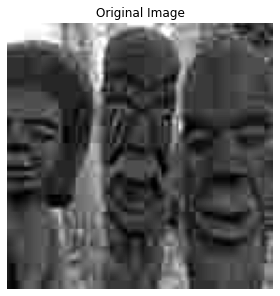

In [12]:
num_iters = 0
psnr_tot = 0
stride_test = args.stride_test

loader = loaders['test']
batch = list(loader)[args.testidx]
batch = batch.to(device=device)

noise = torch.randn_like(batch) * noise_std
noisy_batch = batch + noise

f, axs = plt.subplots(1, 1, constrained_layout=True);
ax = axs;
ax.imshow(batch[0,0], cmap='gray');
ax.set_title("Original Image");
# axs[1].imshow(noisy_batch[0,0], cmap='gray');
# axs[1].set_title("Noised Image");
ax.axis('off');
# axs[1].axis('off');
plt.show();

# Run Group SC Algorithm

In [13]:
# Disable pytorch gradient calculations (we're in test mode)
with torch.set_grad_enabled(False):
    params = {
        'crop_out_blocks': 0,
        'ponderate_out_blocks': 1,
        'sum_blocks': 0,
        'pad_even': 1,  # otherwise pad with 0 for las
        'centered_pad': 0,  # corner pixel have only one estimate
        'pad_block': args.pad_block,  # pad so each pixel has S**2 estimate
        'pad_patch': args.pad_patch,  # pad so each pixel from the image has at least S**2 estimate from 1 block
        'no_pad': args.no_pad,
        'custom_pad': args.custom_pad,
        'avg': 1}

    # Split input image into N separate patch, with some stride
    block = block_module(args.patch_size, stride_test, args.kernel_size, params)
    batch_noisy_blocks = block._make_blocks(noisy_batch)
    patch_loader = torch.utils.data.DataLoader(batch_noisy_blocks, batch_size=args.test_batch, drop_last=False)

    # Run each patch through the neural network to denoise it
    batch_out_blocks = torch.zeros_like(batch_noisy_blocks)
    for i, inp in enumerate(tqdm(patch_loader)):  # if it doesnt fit in memory
        id_from, id_to = i * patch_loader.batch_size, (i + 1) * patch_loader.batch_size
        batch_out_blocks[id_from:id_to] = model(inp)

    # Take a mean of our blocks, recombine them into our output image
    output = block._agregate_blocks(batch_out_blocks)

100%|███████████████████████████████████████████| 26/26 [05:19<00:00, 12.30s/it]


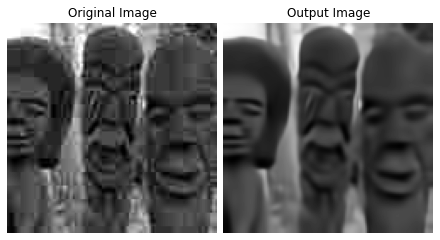

In [14]:
f, axs = plt.subplots(1, 2, constrained_layout=True);
axs[0].imshow(batch[0,0], cmap='gray');
axs[0].set_title("Original Image");
#     axs[1].imshow(noisy_batch[0,0], cmap='gray');
#     axs[1].set_title("Noised Image");
axs[1].imshow(output[0,0], cmap='gray');
axs[1].set_title("Output Image");
axs[0].axis('off');
axs[1].axis('off');
#     axs[2].axis('off');
plt.show();